In [2]:
# Import required libraries
from PIL import Image
import os
import random
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input

Mounted at /content/drive


In [3]:
# Cleanup previous dataset directories if they exist
!rm -rf Damaged_Cars/
!rm -rf Undamaged_Cars/
!rm -rf best_checkpoint/
!rm -rf data1a/
!rm -rf dataset/

In [4]:
# Create a new directory for dataset zips and copy datasets
!mkdir dataset_zip

# Unzip datasets and organize them into respective folders
!unzip -qo dataset_zip/Damaged_Cars/Damaged_Cars.zip
!unzip -qo dataset_zip/Undamaged_Cars/Undamaged_Cars.zip
!rm -rf dataset_zip  # Clean up the zip directory after extraction

In [5]:
!unzip -qo data_final.zip
!rm data_final.zip

--2024-02-24 18:21:36--  https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/data_final.zip
Resolving cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)... 52.219.158.187, 52.219.156.191, 16.12.40.63, ...
Connecting to cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)|52.219.158.187|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128654048 (123M) [application/x-zip-compressed]
Saving to: ‘data_final.zip’

data_final.zip      100%[===================>] 122.69M  12.3MB/s    in 11s     

2024-02-24 18:21:49 (10.7 MB/s) - ‘data_final.zip’ saved [128654048/128654048]



In [6]:
def move_no_replace(source_dir, target_dir):
    """Moves files from source_dir to target_dir without overwriting existing files."""
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    files_moved = 0
    for filename in os.listdir(source_dir):
        source_file = os.path.join(source_dir, filename)
        target_file = os.path.join(target_dir, filename)

        if os.path.exists(target_file):
            base, extension = os.path.splitext(filename)
            counter = 1
            new_filename = f"{base}_{counter}{extension}"
            while os.path.exists(os.path.join(target_dir, new_filename)):
                counter += 1
                new_filename = f"{base}_{counter}{extension}"
            target_file = os.path.join(target_dir, new_filename)
            print(f"Renaming and moving: {source_file} to {new_filename}")

        shutil.move(source_file, target_file)
        files_moved += 1

    print(f"Moved {files_moved} files from {source_dir} to {target_dir}.")

# Example usage
move_no_replace("data1a/training/00-damage", "Damaged_Cars")
move_no_replace("data1a/training/01-whole", "Undamaged_Cars")
move_no_replace("data1a/validation/00-damage", "Damaged_Cars")
move_no_replace("data1a/validation/01-whole", "Undamaged_Cars")


Moved 920 files from data1a/training/00-damage to Damaged_Cars.
Moved 920 files from data1a/training/01-whole to Undamaged_Cars.
Renaming and moving: data1a/validation/00-damage/0073.JPEG to 0073_1.JPEG
Renaming and moving: data1a/validation/00-damage/0060.JPEG to 0060_1.JPEG
Renaming and moving: data1a/validation/00-damage/0041.JPEG to 0041_1.JPEG
Renaming and moving: data1a/validation/00-damage/0227.JPEG to 0227_1.JPEG
Renaming and moving: data1a/validation/00-damage/0013.JPEG to 0013_1.JPEG
Renaming and moving: data1a/validation/00-damage/0171.JPEG to 0171_1.JPEG
Renaming and moving: data1a/validation/00-damage/0083.JPEG to 0083_1.JPEG
Renaming and moving: data1a/validation/00-damage/0096.JPEG to 0096_1.JPEG
Renaming and moving: data1a/validation/00-damage/0116.JPEG to 0116_1.JPEG
Renaming and moving: data1a/validation/00-damage/0024.JPEG to 0024_1.JPEG
Renaming and moving: data1a/validation/00-damage/0133.JPEG to 0133_1.JPEG
Renaming and moving: data1a/validation/00-damage/0207.JPE

In [7]:
!rm -rf dataset

In [8]:
def check_images_in_folder(folder_path):
    """
    Check and collect invalid image files in a given folder.

    Parameters:
    - folder_path: The path to the folder containing the images.

    Returns:
    - A list of invalid image filenames.
    """
    valid_images = []
    invalid_images = []

    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            with Image.open(file_path) as img:
                img.verify()  # Verify if it's an image
            valid_images.append(filename)
        except (IOError, SyntaxError) as e:
            invalid_images.append(filename)
    return invalid_images

def get_image_paths(directory):
    """
    Get paths for all image files in a directory.

    Parameters:
    - directory: The directory to search for image files.

    Returns:
    - A list of paths to image files.
    """
    return [os.path.join(directory, file) for file in os.listdir(directory) if file.lower().endswith(('.png', '.jpg', '.jpeg'))]

def undersample_paths(dir1, dir2):
    """
    Create balanced classes by undersampling image paths from two directories.

    Parameters:
    - dir1: Path to the first directory.
    - dir2: Path to the second directory.

    Returns:
    - Two lists of image paths, balanced by the smaller class size.
    """
    paths1 = get_image_paths(dir1)
    paths2 = get_image_paths(dir2)

    # Determine the smaller size between the two directories
    min_count = min(len(paths1), len(paths2))

    # Randomly sample paths to balance the classes
    paths1 = random.sample(paths1, min_count) if len(paths1) > min_count else paths1
    paths2 = random.sample(paths2, min_count) if len(paths2) > min_count else paths2

    return paths1, paths2

def split_data(paths, train_ratio, test_ratio):
    """
    Split a list of paths into training, testing, and validation sets based on provided ratios.

    Parameters:
    - paths: The list of paths to split.
    - train_ratio: The ratio of paths to be used for training.
    - test_ratio: The ratio of paths to be used for testing.

    Returns:
    - Three lists of paths corresponding to the training, testing, and validation sets.
    """
    random.shuffle(paths)
    train_size = int(len(paths) * train_ratio)
    test_size = int(len(paths) * test_ratio)

    train_paths = paths[:train_size]
    test_paths = paths[train_size:train_size + test_size]
    val_paths = paths[train_size + test_size:]

    return train_paths, test_paths, val_paths

def copy_files(file_paths, destination):
    """
    Copy a list of files to a specified destination.

    Parameters:
    - file_paths: A list of file paths to copy.
    - destination: The destination directory path.
    """
    for path in file_paths:
        shutil.copy(path, destination)

# Directory setup for processing
dir1 = 'Damaged_Cars'
dir2 = 'Undamaged_Cars'

# Remove invalid images from both directories
for folder in [dir1, dir2]:
    invalid_images = check_images_in_folder(folder)
    for invalid_image in invalid_images:
        os.remove(os.path.join(folder, invalid_image))
        print(f"Removed invalid image: {invalid_image}")

# Balance the dataset by undersampling
balanced_paths1, balanced_paths2 = undersample_paths(dir1, dir2)

# Define data splitting ratios
train_ratio = 0.7
test_ratio = 0.1
# Note: Validation ratio is implicitly determined as 1 - train_ratio - test_ratio

# Prepare dataset directory structure
dataset_base = 'dataset'
subfolders = ['train', 'test', 'validation']
for subfolder in subfolders:
    os.makedirs(os.path.join(dataset_base, subfolder, dir1), exist_ok=True)
    os.makedirs(os.path.join(dataset_base, subfolder, dir2), exist_ok=True)

# Split and copy files into respective dataset directories
for paths, class_name in zip([balanced_paths1, balanced_paths2], [dir1, dir2]):
    train, test, val = split_data(paths, train_ratio, test_ratio)
    copy_files(train, os.path.join(dataset_base, 'train', class_name))
    copy_files(test, os.path.join(dataset_base, 'test', class_name))
    copy_files(val, os.path.join(dataset_base, 'validation', class_name))

print("Data successfully split and copied into the dataset folder.")


Removed invalid image: .DS_Store
Removed invalid image: DPt8y4MuGLLqrM.jpg
Removed invalid image: nPI1plBku-ZD1M.jpg
Removed invalid image: Zp5HSkz4B2prRM.jpg
Removed invalid image: 50PYbIvq7UBYhM.jpg
Removed invalid image: tMz-ivnVKZubCM.jpg
Removed invalid image: njbaSQCRRyICzM.jpg
Removed invalid image: .DS_Store
Data successfully split and copied into the dataset folder.


In [9]:
def create_dataset_from_dir(dir):
    """
    Create a TensorFlow dataset from a directory.

    Parameters:
    - dir: The directory path that contains the dataset, organized into subdirectories for each class.

    Returns:
    - A TensorFlow dataset object ready for model training or evaluation.
    """
    dataset = tf.keras.utils.image_dataset_from_directory(
        dir,
        labels="inferred",  # Infer labels from the subdirectory names in 'dir'
        label_mode="categorical",  # For multi-class classification problems
        color_mode="rgb",  # Load images in RGB mode
        batch_size=32,  # Number of images to include in each batch
        image_size=(224, 224),  # Resize images to 224x224 for model input
        shuffle=True,  # Shuffle the images
        seed=42,  # Seed for reproducibility
        interpolation="bilinear"  # Interpolation method used when resizing images
    )
    return dataset

# Load the training, validation, and testing datasets
print("Training:")
training_set = create_dataset_from_dir('dataset/train')
print("\nValidation:")
validation_set = create_dataset_from_dir('dataset/validation')
print("\nTesting:")
testing_set = create_dataset_from_dir('dataset/test')

# Display basic information about the datasets
print(f"\nTraining dataset batches: {len(training_set)}")
print(f"Validation dataset batches: {len(validation_set)}")
print(f"Testing dataset batches: {len(testing_set)}")


Training:
Found 2246 files belonging to 2 classes.

Validation:
Found 644 files belonging to 2 classes.

Testing:
Found 320 files belonging to 2 classes.

Training dataset batches: 71
Validation dataset batches: 21
Testing dataset batches: 10


In [10]:
# Display some metadata about the datasets
print("Classes:", training_set.class_names)  # Print class names
print("Number of batches:", len(training_set))  # Print the number of batches in the training set

# Example of accessing and printing metadata for a single batch
for images, labels in training_set.take(1):  # Access a single batch
    print("Batch shape:", images.shape)  # Print shape of the batch (images)
    print("Label shape:", labels.shape)  # Print shape of the labels
    print("First 10 labels in the first batch:", labels[:10])  # Print first 10 labels of the batch

Classes: ['Damaged_Cars', 'Undamaged_Cars']
Number of batches: 71
Batch shape: (32, 224, 224, 3)
Label shape: (32, 2)
First 10 labels in the first batch: tf.Tensor(
[[0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]], shape=(10, 2), dtype=float32)


In [11]:
checkpoint = ModelCheckpoint(
    './best_checkpoint',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=False,
    save_frequency=1
)

In [12]:
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=50,
    verbose=1,
    mode='auto'
)

In [13]:
def upload_misclassified_images(testing_set, model):
    labels = ["00-damage", "01-whole"]
    output_dir = 'misclassified_images'
    os.makedirs(output_dir, exist_ok=True)

    image_info = []

    # Iterate over all batches in the testing set
    for batch_index, (images, truths) in enumerate(testing_set):
        for i, image in enumerate(images):
            # Preprocess and predict
            net_input = tf.image.resize(image, (224, 224))
            net_input = np.expand_dims(net_input, axis=0)
            prediction = np.argmax(model.predict(net_input))
            truth = np.argmax(truths[i])
            if prediction != truth:
              # Save image as JPEG
              image_path = os.path.join(output_dir, f'image_{batch_index}_{i}.jpg')
              tf.keras.utils.save_img(image_path, image.numpy())

              # Append path, label, and prediction to the list
              image_info.append((image_path, labels[truth], labels[prediction]))
              #run[f"misclassified_images/{temp_file}"].upload(temp_file)

    return image_info

In [14]:
def plot_test_images():
  labels = ["00-damage", "01-whole"]

  it = iter(testing_set)
  batch = next(it)  # Gets a batch of 16 test images

  fig, axes = plt.subplots(3, 3, figsize=(10, 10))
  fig.tight_layout()
  fig.subplots_adjust(hspace=.25)

  for i in range(3):
      for j in range(3):
          ax = axes[i, j]
          image = batch[0][i * 3 + j]
          net_input = tf.image.resize(image, (224, 224))  # Resizing to the expected input size of the model
          net_input = np.expand_dims(net_input, axis=0)  # Adding batch dimension
          truth = np.argmax(batch[1][i * 3 + j])  # One-hot to label index
          prediction = np.argmax(model.predict(net_input))
          ax.set_title('Label: %s\nPrediction: %s' % (labels[truth], labels[prediction]))
          ax.imshow(image.numpy().astype("uint8"))  # Converting tensor to numpy array for display
  return fig

58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/100
71/71 [==============================] - ETA: 0s - loss: 7.4719 - accuracy: 0.7155
Epoch 1: val_accuracy improved from -inf to 0.79037, saving model to ./best_checkpoint
71/71 [==============================] - 40s 376ms/step - loss: 7.4719 - accuracy: 0.7155 - val_loss: 1.0861 - val_accuracy: 0.7904
Epoch 2/100
70/71 [============================>.] - ETA: 0s - loss: 1.5398 - accuracy: 0.7268
Epoch 2: val_accuracy did not improve from 0.79037
71/71 [==============================] - 22s 282ms/step - loss: 1.5398 - accuracy: 0.7257 - val_loss: 0.5009 - val_accuracy: 0.7391
Epoch 3/100
70/71 [============================>.] - ETA: 0s - loss: 0.9498 - accuracy: 0.7143
Epoch 3: val_accuracy improved from 0.79037 to 0.81988, saving model to ./best_checkpoint
71/71 [==============================] - 22s 288ms/step - loss: 0.9479 - accuracy: 0.7146 - val_loss: 0.5189 - val_accuracy: 0.8199
Epoch 4/100
70/71 [=======

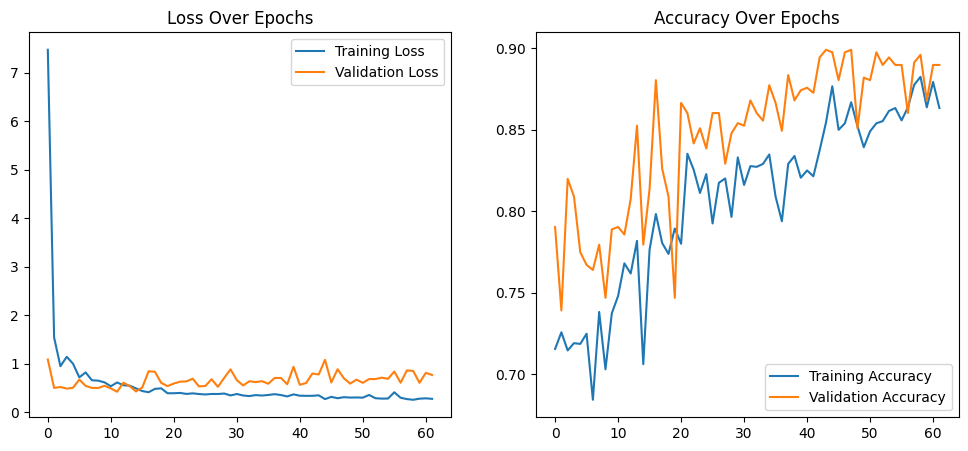

1/1 [==============================] - 0s 30ms/step
Misclassified Image: misclassified_images/image_0_1.jpg, True Label: 01-whole, Predicted Label: 00-damage
Misclassified Image: misclassified_images/image_0_12.jpg, True Label: 00-damage, Predicted Label: 01-whole
Misclassified Image: misclassified_images/image_0_13.jpg, True Label: 01-whole, Predicted Label: 00-damage
Misclassified Image: misclassified_images/image_0_30.jpg, True Label: 01-whole, Predicted Label: 00-damage
Misclassified Image: misclassified_images/image_0_31.jpg, True Label: 01-whole, Predicted Label: 00-damage
Misclassified Image: misclassified_images/image_1_15.jpg, True Label: 00-damage, Predicted Label: 01-whole
Misclassified Image: misclassified_images/image_2_4.jpg, True Label: 01-whole, Predicted Label: 00-damage
Misclassified Image: misclassified_images/image_2_9.jpg, True Label: 01-whole, Predicted Label: 00-damage
Misclassified Image: misclassified_images/image_2_12.jpg, True Label: 01-whole, Predicted Label

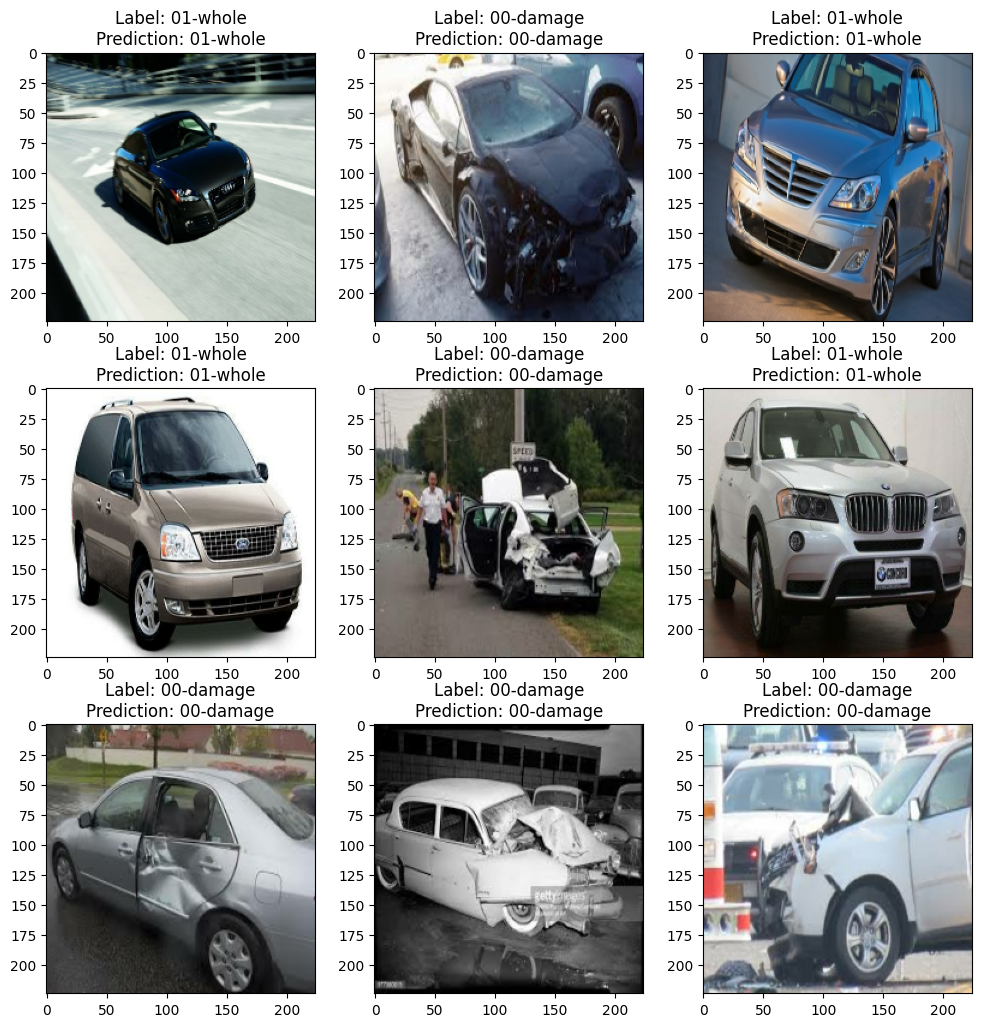

In [15]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input

# Load the pre-trained VGG16 model without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Building the model
model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

# Define callbacks
callbacks = [checkpoint, earlystop]

# Fit the model
history = model.fit(training_set,
                    epochs=100,
                    steps_per_epoch=len(training_set),
                    validation_data=validation_set,
                    validation_steps=len(validation_set),
                    callbacks=callbacks)

# Save the model or checkpoint as needed
model.save("best_checkpoint")

# Evaluate the model on the test set
loss, accuracy = model.evaluate(testing_set)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# Save and plot your training history for loss and accuracy

def plot_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()
    plt.show()

plot_history(history)

# Call to plot a selection of test images with their predicted labels
plot_test_images()

# Call to find and save misclassified images, then print or handle their information as needed
misclassified_images_info = upload_misclassified_images(testing_set, model)
for img_info in misclassified_images_info:
    print(f"Misclassified Image: {img_info[0]}, True Label: {img_info[1]}, Predicted Label: {img_info[2]}")

In [16]:
!rm -rf misclassified_images
!rm -rf Damaged_Cars
!rm -rf Undamaged_Cars
!rm -rf best_checkpoint